# Build the get_proteomics_data() function for dash app and general querying

Adapting from `src/dash/data.py` function `get_metabolomics_data()` and `1.0_get_lipidomics_data.ipynb`

In [75]:
from sqlalchemy import create_engine, MetaData, Table, select, join
import pandas as pd

# SQLite path (updated to include new version of proteomics data)
db_path = 'sqlite:///../../../data/SQLite Database/20200528/Covid-19 Study DB.sqlite'
db_path = 'sqlite:////Volumes/projects/All_20200428_COVID_plasma_multiomics/SQLite Database/Covid-19 Study DB.sqlite'


def get_proteomics_data(with_metadata=False):
    # Create an engine that connects to the Covid-19 Study DB.sqlite file: engine
    engine = create_engine(db_path)

    # Establish connection
    connection = engine.connect()

    # pull table into df
    proteomics_measurements_df = pd.read_sql_query("SELECT * from proteomics_measurements", connection)

    # pull table into df
    proteomics_runs_df = pd.read_sql_query("SELECT * from proteomics_runs", connection)

    # pull table into df
    rawfiles_df = pd.read_sql_query("SELECT * from rawfiles WHERE ome_id=1 AND sample_ID<>-1 and keep=1", connection)

    # pull table into df
    deidentified_patient_metadata_df = pd.read_sql_query("SELECT * from deidentified_patient_metadata", connection)

    # make sure the merge by columns are all the same type -> pandas seems sensitive to this
    proteomics_measurements_df = proteomics_measurements_df.astype({'replicate_id': 'int32'})
    proteomics_runs_df = proteomics_runs_df.astype({'replicate_id': 'int32', 'rawfile_id': 'int32'})
    rawfiles_df = rawfiles_df.astype({'rawfile_id': 'int32', 'sample_id': 'int32'})
    deidentified_patient_metadata_df = deidentified_patient_metadata_df.astype({'sample_id': 'int32'})

    joined_df = proteomics_measurements_df\
                .join(proteomics_runs_df.set_index('replicate_id'), on='replicate_id')\
                .join(rawfiles_df.set_index('rawfile_id'), on='rawfile_id')\
                .join(deidentified_patient_metadata_df.set_index('sample_id'), on='sample_id')

    # drop samples that are missing COVID or ICU status
    joined_df.dropna(subset=['ICU_1','COVID'], inplace=True)

    # pivot to wide format
    wide_df = joined_df.pivot_table(index='sample_id', columns='biomolecule_id', values='normalized_abundance')
    wide_df.columns = [str(col) for col in wide_df.columns]

    # get biomolecule names
    biomolecules_df = pd.read_sql_query("SELECT * from biomolecules WHERE omics_id=1", connection)
    
    # close DB connection
    connection.close()

    # build biomolecule name dict 
    biomolecule_name_dict = {}
    biomolecule_drop_list = []
    for index, row in biomolecules_df.iterrows():
        biomolecule_id = str(row['biomolecule_id'])
        standardized_name = row['standardized_name']
        biomolecule_name_dict[biomolecule_id] = standardized_name

        keep = row['keep']
        if keep!="1":
            biomolecule_drop_list.append(biomolecule_id)

    # replace wide_df column names
    """new_col_names = []
    for col in wide_df.columns:
        new_col_names.append(biomolecule_name_dict[str(col)])
    wide_df.columns = new_col_names"""

    # optional return matrix with clinical metadata
    if with_metadata:

        combined_df = wide_df.join(deidentified_patient_metadata_df.set_index('sample_id'), on='sample_id')#.dropna()
        return combined_df
    
    return wide_df

In [76]:
proteomics_df = get_proteomics_data(with_metadata=True)
proteomics_df

,7593,7594,7595,7596,7597,7598,7599,7600,7601,7602,...,Albany_sampleID,COVID,Hospital_free_days,Age_less_than_90,Gender,ICU_1,APACHEII,Charlson_score,Mech_Ventilation,Vent_free_days
sample_id,,,,,,,,,,,,,,,,,,,,,
1.0,37.995543,22.751400,22.122531,27.176361,28.294477,22.830609,24.783368,23.926601,23.490571,25.490816,...,C1,1,0,39,M,0,15,0,1,0
2.0,37.353091,21.477142,21.106922,29.419228,29.048510,26.660849,27.573331,24.671039,22.343591,27.166913,...,C2,1,22,63,M,0,,2,0,28
3.0,37.527875,20.647824,19.148225,27.174171,28.953215,20.212142,25.619161,24.528623,20.714471,25.589237,...,C3,1,1,33,M,0,,2,0,28
4.0,37.673128,21.828886,23.396629,28.879702,29.527460,26.439300,23.893562,25.875326,24.170967,25.280226,...,C4,1,22,49,M,0,,1,0,28
5.0,37.983542,18.769891,18.695882,27.262485,28.605867,22.957979,18.440251,20.888495,17.354782,25.654472,...,C5,1,10,49,M,0,19,1,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124.0,37.365447,18.888922,22.348868,27.133006,29.418182,25.645154,26.724164,24.374313,24.805480,27.039675,...,NC21,0,19,71,M,0,,5,0,28
125.0,37.564109,19.975562,24.375109,27.793462,29.003245,26.466999,26.577443,25.152285,24.429947,26.009474,...,NC22,0,26,63,M,0,4,2,0,28
126.0,37.683884,18.226595,19.727447,26.876193,28.002763,20.797804,27.996742,24.717171,23.581184,26.701340,...,NC23,0,23,42,F,0,,2,0,28


# Test functions

In [77]:
color_dict = {
                "COVID_ICU":"#D53E4F",
                "COVID_NONICU":"#FDAE61",
                "NONCOVID_ICU":"#74ADD1",
                "NONCOVID_NONICU":"#66C2A5",
                "Male":"#F46D43",
                "Female":"#5AAE61",
                "Col7":"#8073AC",
                "Col8":"#DE77AE",
                "proteomics":"#9E0142",
                "lipidomics":"#F4A582",
                "metabolomics":"#2A4023",
                "transcriptomics":"#2C0379",
                "selected_biomolecule":"black"
                }

def get_color_list(combined_df):
    # from combined_df

    # get colors
    color_list = []
    for sample_id, row in combined_df.iterrows():

        ICU_1 = row['ICU_1']
        COVID = row['COVID']

        if pd.isnull(ICU_1):
            color = "Col12"

        elif ICU_1 == "1" and COVID == "1":
            color = color_dict["COVID_ICU"]
            color = "COVID_ICU"

        elif ICU_1 == "1" and COVID == "0":
            color = color_dict["NONCOVID_ICU"]
            color = "NONCOVID_ICU"

        elif ICU_1 == "0" and COVID == "1":
            color = color_dict["COVID_NONICU"]
            color = 'COVID_NONICU'

        elif ICU_1 == "0" and COVID == "0":
            color = color_dict["NONCOVID_NONICU"]
            color = "NONCOVID_NONICU"

        color_list.append(color)

    return color_list

In [78]:
color_list = get_color_list(proteomics_df)

In [79]:
proteomics_df['color_by'] = color_list

In [80]:
proteomics_df.to_csv("../../../data/proteomics_measurements_w_clinical_metadata.csv")

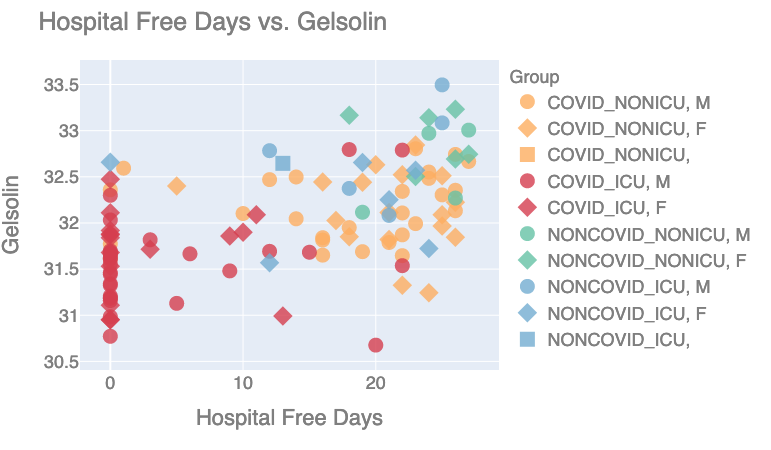

In [70]:
import plotly.express as px

fig = px.scatter(proteomics_df, y="7974", x="Hospital_free_days", hover_data=['Gender', 'Age_less_than_90'],
                color=color_list,
                color_discrete_map=color_dict,
                symbol='Gender')

fig.update_traces(marker=dict(size=15, opacity=0.8))

fig.update_layout(
    title="Hospital Free Days vs. Gelsolin",
    legend_title_text='Group',
    xaxis_title='Hospital Free Days',
    yaxis_title='Gelsolin',
    showlegend=True,
    font=dict(
        family="Helvetica",
        size=18,
        color="#7f7f7f")
    )

fig.show()

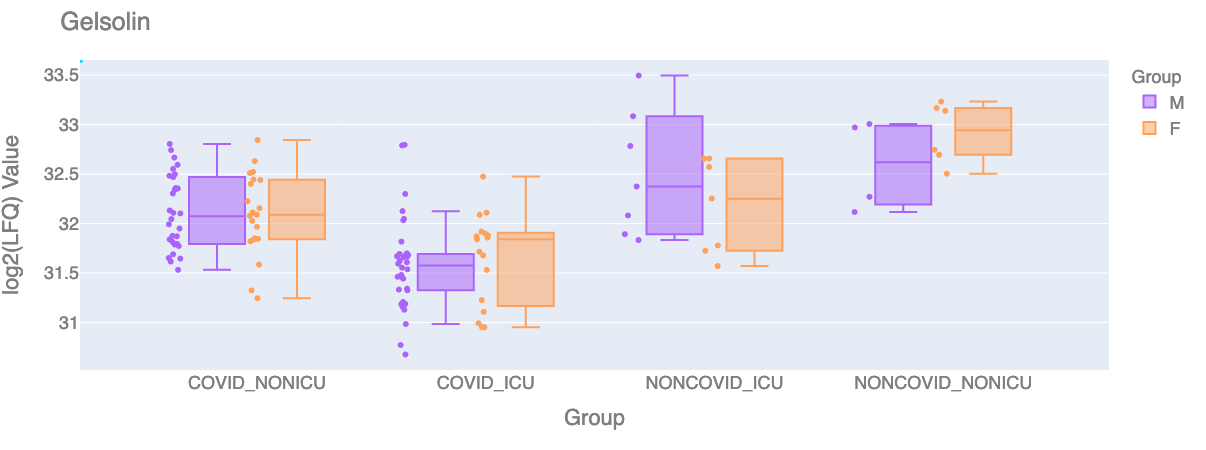

In [74]:
biomolecule_name = "7974"

fig = px.box(proteomics_df, y=biomolecule_name, color="Gender", x='color_by', color_discrete_map=color_dict,
            points='all')

fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.update_layout(
    title="{}".format("Gelsolin"),
    legend_title_text='Group',
    xaxis_title='Group',
    yaxis_title='log2(LFQ) Value',
    font=dict(
        family="Helvetica",
        size=18,
        color="#7f7f7f"))
